# Relative Reconstruction Error

In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
from core.mesh_data import DataModule
from core.PVCAE.model import Model

In [2]:
dm = DataModule(data_dir='../data/flow_mesh',
                spatial_dim=2,
                num_points=7613,
                batch_size=128,
                channels=[0])

trainer = pl.Trainer(accelerator='gpu', devices=1, logger=False)

conv_params = {"in_channels":[1,8],
                "out_channels":[8,16],
                "kernel_size":[3],
                "bias":[False],
                "padding": ["same"]}
point_params = {"in_channels":[1,2],
            "out_channels":[2,2],
            "bias":[False]}

path = 'flow/pvcae/version_0/checkpoints/epoch=323.ckpt'
model = Model.load_from_checkpoint('../lightning_logs/'+path,
                                  data_info=dm.get_data_info(),
                                  conv_params=conv_params,
                                  point_params=point_params,
                                  vox_size=[0.02, 0.02])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
out = trainer.test(model=model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_avg_err           0.250262588262558
      test_max_err          0.7597109079360962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Images/GIFs

In [4]:
import gif
import matplotlib.pyplot as plt

In [5]:
pred = trainer.predict(model=model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [6]:
pred[0].shape

torch.Size([128, 1, 7613])

In [7]:
pred = dm.agglomerate(pred)
print(pred.shape)

torch.Size([300, 7613, 1])


## Make GIF

In [8]:
pred = pred.squeeze()

plot_func = dm.get_plot_func()

@gif.frame
def plot(i):
    fig, ax = plt.subplots(1, 2)

    plot_func(dm.get_sample(i), ax[0])
    ax[0].set_title("Uncompressed")

    im = plot_func(pred[i,...], ax[1])
    ax[1].set_title("Reconstructed")

    if dm.spatial_dim == 2:
        # mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        fig.colorbar(im, ax=ax.ravel().tolist(), location='bottom')

In [9]:
#build frames
frames = [plot(i) for i in range(pred.shape[0])]

#save gif
gif.save(frames, "best.gif", duration=50)

## Make Image

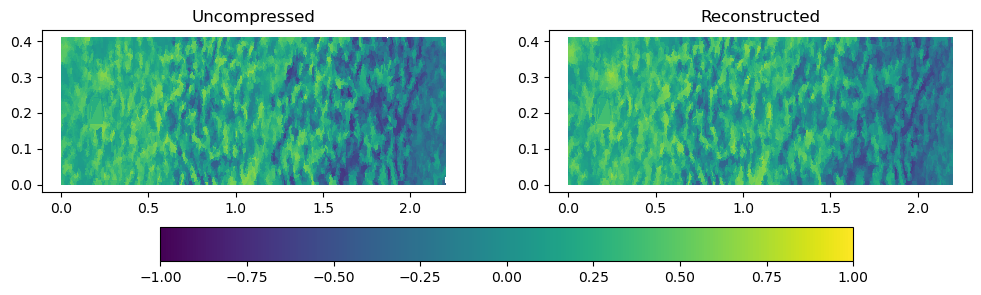

In [26]:
t = 60

plot_func = dm.get_plot_func()

fig, ax = plt.subplots(1, 2, figsize=(12,3))

plot_func(dm.get_sample(t), ax[0])
ax[0].set_title("Uncompressed")

im = plot_func(pred[t,...], ax[1])
ax[1].set_title("Reconstructed")

fig.colorbar(im, ax=ax.ravel().tolist(), location='bottom')

In [13]:
fig.savefig(f"error_{t}.png")

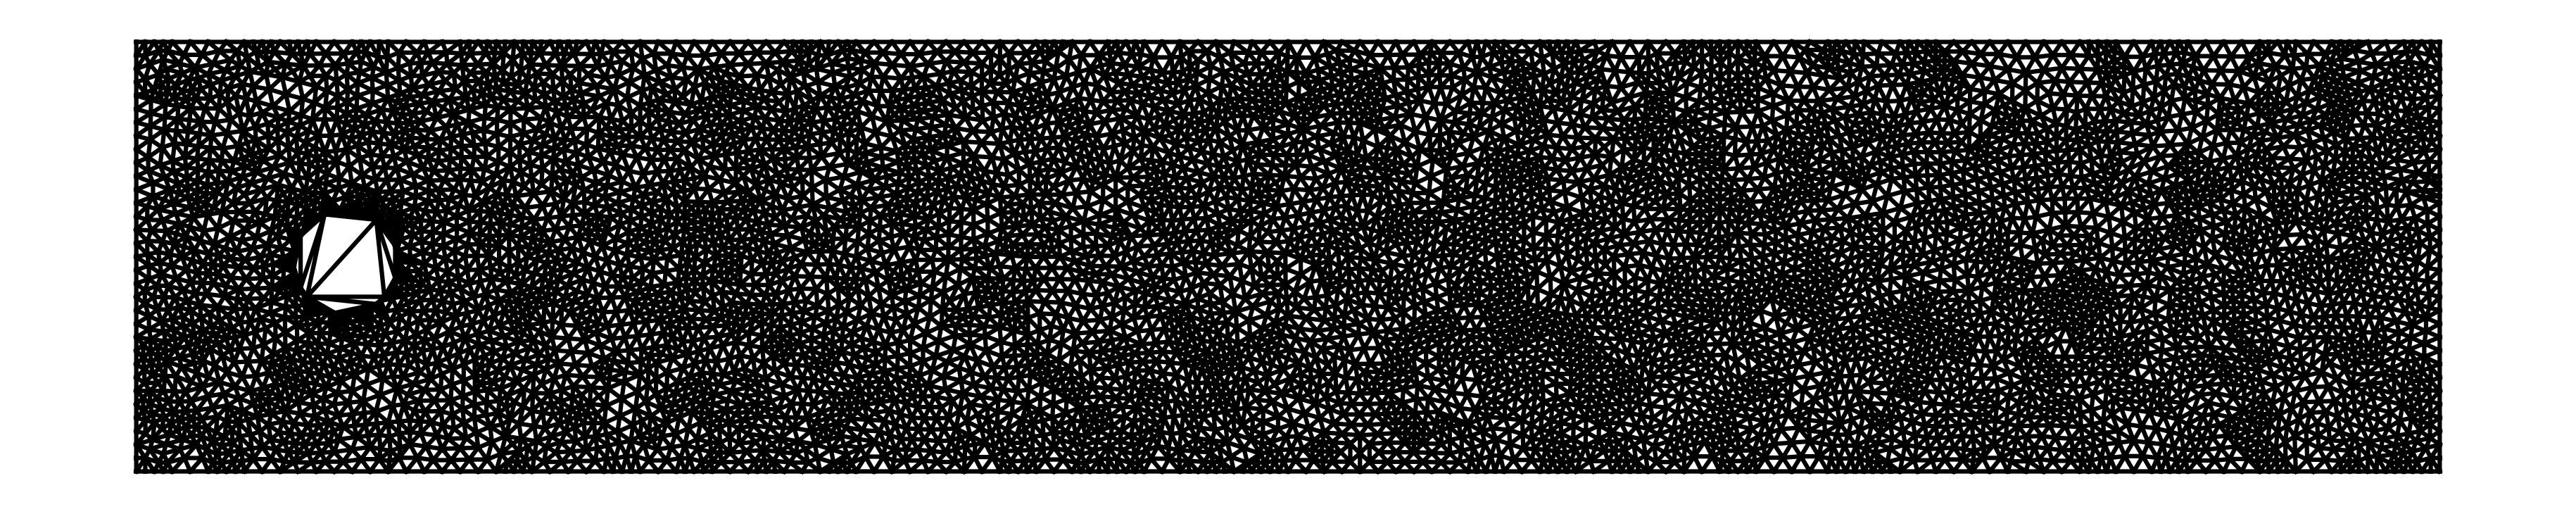

In [22]:
flow_tri = dm._triangulation

fig_tri = plt.figure(figsize=(12,3.8), dpi=300)

ax_tri = fig_tri.add_axes([0,0,1,1])

ax_tri.triplot(flow_tri, color='black')

ax_tri.axis('off')
ax_tri.set_aspect('equal')